## Extensive Feature Extraction for Stock Prediction


The previous workbook showsed a workflow adopted to extract features need for the stock prediction and portfolio optimization. To make this workflow more universal, a pipeline has been developed to ensure that the feature extraction workflow is properly reusable. Go through this notebook to checkout the pipeline used for feature extraction.

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
import talib

from typing import TypeVar, Callable, Sequence
from functools import reduce
T = TypeVar('T')


%matplotlib inline
os.chdir(r'C:\Users\Israel\Documents\GitHub\Stock-Portfolio-Optimization')

### Pipeline to Scrape the Historical Stocks data and Extract features from it. 

Initiating Pipeline....
Loading Historical Price data for GS....
{'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'GS', '3. Last Refreshed': '2020-04-17', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}


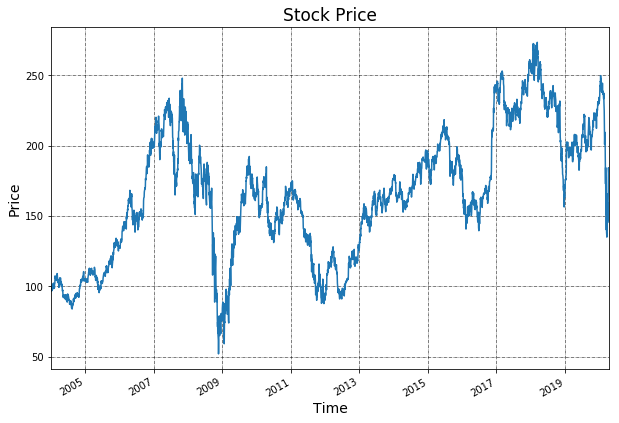

 
Feature extraction of technical Indicators....
Boolinger bands..
Lagged Price data for previous days....
Simple Moving Average....
Exponential Moving Average....
Commodity Channel Index....
Stocastic %K ....
Force index....


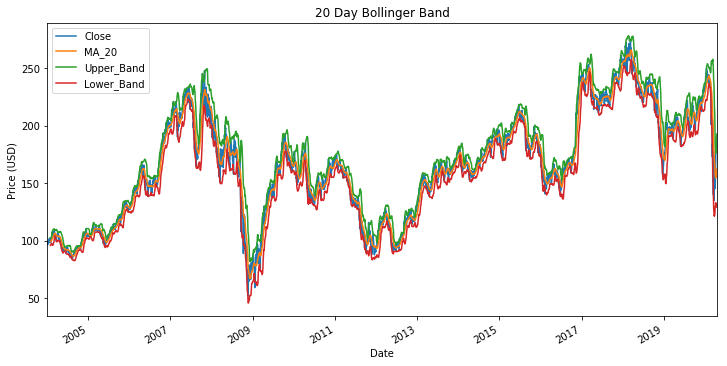

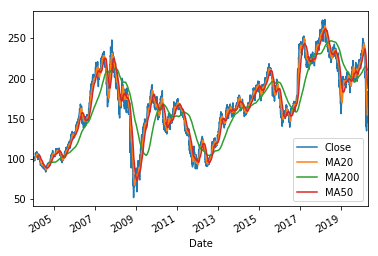

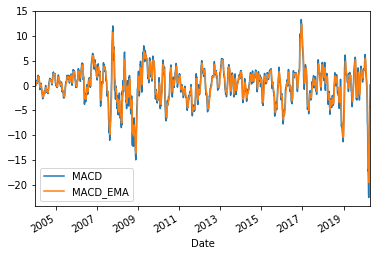

 
Extracting information from dates....
 
Fetching data for NASDAQ-100 Index Fund ETF QQQ & S&P 500 index ......
 
Adding the future day close price as a target column for Forcast Horizon of 1
Saving extracted features data in S3 Bucket....
Extracted features shape - (3901, 63)
 
Extracted features dataframe - 
              Open     High      Low  Close(t)     Volume       SD20  \
Date                                                                   
2004-10-18   94.16   94.450   93.090     94.25  2572100.0   0.789807   
2004-10-19   94.25   95.000   92.600     93.06  4144600.0   0.783158   
2004-10-20   92.11   92.690   90.740     92.34  3934700.0   0.850070   
2004-10-21   92.00   93.850   91.980     93.47  4023000.0   0.835898   
2004-10-22   93.02   93.740   92.010     92.70  3515900.0   0.871389   
...            ...      ...      ...       ...        ...        ...   
2020-04-09  180.58  187.328  179.770    184.26  6445448.0  12.984412   
2020-04-13  183.85  184.970  179.130   

In [21]:

class Stocks:
    def __init__(self, ticker, start_date, forcast_horz):
        self.Ticker = ticker
        self.Start_Date = start_date
        self.forcast_horz = forcast_horz
        
    
    def get_stock_data(self, Ticker):
    
        ALPHA_VANTAGE_API_KEY = 'XAGC5LBB1SI9RDLW'
        self.ts = TimeSeries(key= ALPHA_VANTAGE_API_KEY, output_format='pandas')
        print('Loading Historical Price data for ' + self.Ticker + '....')
        self.df_Stock, self.Stock_info = self.ts.get_daily(self.Ticker, outputsize='full') 
        print(self.Stock_info)
        self.df_Stock = self.df_Stock.rename(columns={'1. open' : 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'Close', '5. volume': 'Volume' })
        self.df_Stock = self.df_Stock.rename_axis(['Date'])
        #sorting index
        self.Stock = self.df_Stock.sort_index(ascending=True, axis=0)
        #slicing the data for 20 years from '2002-01-01' to today
        self.Stock = self.Stock.loc[self.Start_Date:]

        self.Stock['Close'].plot(figsize=(10, 7))
        plt.title("Stock Price", fontsize=17)
        plt.ylabel('Price', fontsize=14)
        plt.xlabel('Time', fontsize=14)
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
        plt.show()

  
    def extract_Technical_Indicators(self, Ticker):
        
        print(' ')
        print('Feature extraction of technical Indicators....')
        #get Boolinger Bands
        self.Stock['MA_20'] = self.Stock.Close.rolling(window=20).mean()
        self.Stock['SD20'] = self.Stock.Close.rolling(window=20).std()
        self.Stock['Upper_Band'] = self.Stock.Close.rolling(window=20).mean() + (self.Stock['SD20']*2)
        self.Stock['Lower_Band'] = self.Stock.Close.rolling(window=20).mean() - (self.Stock['SD20']*2)
        print('Boolinger bands..')

        #shifting for lagged data 
        self.Stock['S_Close(t-1)'] = self.Stock.Close.shift(periods=1)
        self.Stock['S_Close(t-2)'] = self.Stock.Close.shift(periods=2)
        self.Stock['S_Close(t-3)'] = self.Stock.Close.shift(periods=3)
        self.Stock['S_Close(t-5)'] = self.Stock.Close.shift(periods=5)
        self.Stock['S_Open(t-1)'] = self.Stock.Open.shift(periods=1)
        print('Lagged Price data for previous days....')

        #simple moving average
        self.Stock['MA5'] = self.Stock.Close.rolling(window=5).mean()
        self.Stock['MA10'] = self.Stock.Close.rolling(window=10).mean()
        self.Stock['MA20'] = self.Stock.Close.rolling(window=20).mean()
        self.Stock['MA50'] = self.Stock.Close.rolling(window=50).mean()
        self.Stock['MA200'] = self.Stock.Close.rolling(window=200).mean()
        print('Simple Moving Average....')

        #Exponential Moving Averages
        self.Stock['EMA10'] = self.Stock.Close.ewm(span=5, adjust=False).mean().fillna(0)
        self.Stock['EMA20'] = self.Stock.Close.ewm(span=5, adjust=False).mean().fillna(0)
        self.Stock['EMA50'] = self.Stock.Close.ewm(span=5, adjust=False).mean().fillna(0)
        self.Stock['EMA100'] = self.Stock.Close.ewm(span=5, adjust=False).mean().fillna(0)
        self.Stock['EMA200'] = self.Stock.Close.ewm(span=5, adjust=False).mean().fillna(0)
        print('Exponential Moving Average....')

        #Moving Average Convergance Divergances
        self.Stock['EMA_12'] = self.Stock.Close.ewm(span=12, adjust=False).mean()
        self.Stock['EMA_26'] = self.Stock.Close.ewm(span=26, adjust=False).mean()
        self.Stock['MACD'] = self.Stock['EMA_12'] - self.Stock['EMA_26']

        self.Stock['MACD_EMA'] = self.Stock.MACD.ewm(span=9, adjust=False).mean()

        #Average True Range
        self.Stock['ATR'] = talib.ATR(self.Stock['High'].values, self.Stock['Low'].values, self.Stock['Close'].values, timeperiod=14)

        #Average Directional Index
        self.Stock['ADX'] = talib.ADX(self.Stock['High'], self.Stock['Low'], self.Stock['Close'], timeperiod=14)

        #Commodity Channel index
        tp = (self.Stock['High'] + self.Stock['Low'] + self.Stock['Close']) /3
        ma = tp/20 
        md = (tp-ma)/20
        self.Stock['CCI'] = (tp-ma)/(0.015 * md)
        print('Commodity Channel Index....')

        #Rate of Change 
        self.Stock['ROC'] = ((self.Stock['Close'] - self.Stock['Close'].shift(10)) / (self.Stock['Close'].shift(10)))*100

        #Relative Strength Index
        self.Stock['RSI'] = talib.RSI(self.Stock.Close.values, timeperiod=14)

        #William's %R
        self.Stock['William%R'] = talib.WILLR(self.Stock.High.values, self.Stock.Low.values, self.Stock.Close.values, 14) 

        #Stocastic K
        self.Stock['SO%K'] = ((self.Stock.Close - self.Stock.Low.rolling(window=14).min()) / (self.Stock.High.rolling(window=14).max() - self.Stock.Low.rolling(window=14).min())) * 100
        print('Stocastic %K ....')
        #Standard Deviation of last 5 day returns
        self.Stock['per_change'] = self.Stock.Close.pct_change()
        self.Stock['STD5'] = self.Stock.per_change.rolling(window=5).std()

        #Force Index
        self.Stock['ForceIndex1'] = self.Stock.Close.diff(1) * self.Stock.Volume
        self.Stock['ForceIndex20'] = self.Stock.Close.diff(20) * self.Stock.Volume
        print('Force index....')

        #print('Stock Data ', self.Stock)
        
        self.Stock[['Close', 'MA_20', 'Upper_Band', 'Lower_Band']].plot(figsize=(12,6))
        plt.title('20 Day Bollinger Band')
        plt.ylabel('Price (USD)')
        plt.show();
        
        self.Stock[['Close', 'MA20', 'MA200', 'MA50']].plot()
        plt.show();

        self.Stock[['MACD', 'MACD_EMA']].plot()
        plt.show();
        #Dropping unneccesary columns
        self.Stock = self.Stock.drop(columns=['MA_20', 'per_change', 'EMA_12', 'EMA_26'])
        

        
    def extract_info(self, date_val):

        Day = date_val.day
        DayofWeek = date_val.dayofweek
        Dayofyear = date_val.dayofyear
        Week = date_val.week
        Is_month_end = date_val.is_month_end.real
        Is_month_start = date_val.is_month_start.real
        Is_quarter_end = date_val.is_quarter_end.real
        Is_quarter_start = date_val.is_quarter_start.real
        Is_year_end = date_val.is_year_end.real
        Is_year_start = date_val.is_year_start.real
        Is_leap_year = date_val.is_leap_year.real
        Year = date_val.year
        Month = date_val.month

        return Day, DayofWeek, Dayofyear, Week, Is_month_end, Is_month_start, Is_quarter_end, Is_quarter_start, Is_year_end, Is_year_start, Is_leap_year, Year, Month


    def extract_date_features(self, Ticker):
        print(' ')
        self.Stock['Date_col'] = self.Stock.index
        
        self.Stock[['Day', 'DayofWeek', 'DayofYear', 'Week', 'Is_month_end', 'Is_month_start',
          'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Is_leap_year', 'Year', 'Month']] = self.Stock.Date_col.apply(lambda date_val: pd.Series(self.extract_info(date_val)))
        print('Extracting information from dates....')
        
    
    def get_IDXFunds_features(self, Ticker):
        print(' ')
        print('Fetching data for NASDAQ-100 Index Fund ETF QQQ & S&P 500 index ......')
        
        # Nasdaq-100 Index Fund ETF QQQ
        QQQ, QQQ_info = self.ts.get_daily('QQQ', outputsize='full') 
        QQQ = QQQ.rename(columns={'1. open' : 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'QQQ_Close', '5. volume': 'Volume' })
        QQQ = QQQ.rename_axis(['Date'])
        QQQ = QQQ.drop(columns=['Open', 'High', 'Low', 'Volume'])

        #sorting index
        QQQ = QQQ.sort_index(ascending=True, axis=0)
        #slicing the data for 15 years from '2004-01-02' to today
        QQQ = QQQ.loc[self.Start_Date:]
        QQQ['QQQ(t-1)'] = QQQ.QQQ_Close.shift(periods=1)
        QQQ['QQQ(t-2)'] =  QQQ.QQQ_Close.shift(periods=2)
        QQQ['QQQ(t-5)'] =  QQQ.QQQ_Close.shift(periods=5)

        QQQ['QQQ_MA10'] = QQQ.QQQ_Close.rolling(window=10).mean()
        #QQQ['QQQ_MA10_t'] = QQQ.QQQ_ClosePrev1.rolling(window=10).mean()
        QQQ['QQQ_MA20'] = QQQ.QQQ_Close.rolling(window=20).mean()
        QQQ['QQQ_MA50'] = QQQ.QQQ_Close.rolling(window=50).mean()


        #S&P 500 Index Fund 
        SnP, SnP_info = self.ts.get_daily('INX', outputsize='full') 
        SnP = SnP.rename(columns={'1. open' : 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'SnP_Close', '5. volume': 'Volume' })
        SnP = SnP.rename_axis(['Date'])
        SnP = SnP.drop(columns=['Open', 'High', 'Low', 'Volume'])

        #sorting index
        SnP = SnP.sort_index(ascending=True, axis=0)
        #slicing the data for 15 years from '2004-01-02' to today
        SnP = SnP.loc[self.Start_Date:]
        SnP
        SnP['SnP(t-1))'] = SnP.SnP_Close.shift(periods=1)
        SnP['SnP(t-5)'] =  SnP.SnP_Close.shift(periods=5)

        
        #S&P 500 Index Fund 
        DJIA, DJIA_info = self.ts.get_daily('DJI', outputsize='full') 
        DJIA = DJIA.rename(columns={'1. open' : 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'DJIA_Close', '5. volume': 'Volume' })
        DJIA = DJIA.rename_axis(['Date'])
        DJIA = DJIA.drop(columns=['Open', 'High', 'Low', 'Volume'])

        #sorting index
        DJIA = DJIA.sort_index(ascending=True, axis=0)
        #slicing the data for 15 years from '2004-01-02' to today
        DJIA = DJIA.loc[self.Start_Date:]
        DJIA
        DJIA['DJIA(t-1))'] = DJIA.DJIA_Close.shift(periods=1)
        DJIA['DJIA(t-5)'] =  DJIA.DJIA_Close.shift(periods=5)

        
        #Merge index funds 
        IDXFunds = QQQ.merge(SnP, left_index=True, right_index=True)
        IDXFunds = IDXFunds.merge(DJIA, left_index=True, right_index=True)
        self.Stock = self.Stock.merge(IDXFunds, left_index=True, right_index=True)
        
        
        
    def forcast_Horizon(self, Ticker):
    
        print(' ')
        print('Adding the future day close price as a target column for Forcast Horizon of ' + str(self.forcast_horz))
        #Adding the future day close price as a target column which needs to be predicted using Supervised Machine learning models
        self.Stock['Close_forcast'] = self.Stock.Close.shift(-self.forcast_horz)
        self.Stock = self.Stock.rename(columns={'Close': 'Close(t)'})
        self.Stock = self.Stock.dropna()

        
    def save_features(self, Ticker):
        print('Saving extracted features data in S3 Bucket....')
        self.Stock.to_csv(self.Ticker + '.csv')
        print('Extracted features shape - '+ str(self.Stock.shape))
        print(' ')
        print('Extracted features dataframe - ')
        print(self.Stock)
        return self.Stock
        
        
    T = TypeVar('T')

    def pipeline(self,
        value: T,
        function_pipeline: Sequence[Callable[[T], T]],
        ) -> T:
    
        return reduce(lambda v, f: f(v), function_pipeline, value)

    def pipeline_sequence(self):

        print('Initiating Pipeline....')
        z = self.pipeline(
            value=self.Ticker,
            function_pipeline=(
                self.get_stock_data,
                self.extract_Technical_Indicators,
                self.extract_date_features, 
                self.get_IDXFunds_features,
                self.forcast_Horizon,
                self.save_features
                    )
                )

        print(f'z={z}')
        


features = Stocks('GS', '2004-01-02', 1)
features.pipeline_sequence()



### License
MIT License

Copyright (c) 2022 Israel Bassey

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.